<a href="https://colab.research.google.com/github/BalintKomjati/infinite-loop/blob/main/stable-diffusion-2-infinite-zoom-out/infinite_zoom_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 15109 MiB


In [171]:
%pip install -q transformers scipy ftfy accelerate
%pip install -q --upgrade diffusers[torch]

In [3]:
# infinite scroll experiment with inpaintingkkk

import PIL
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import random
import cv2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from IPython.display import clear_output

In [106]:
def write_video(file_path, frames, fps, reversed = True):
    """
    Writes frames to an mp4 video file
    :param file_path: Path to output video, must end with .mp4
    :param frames: List of PIL.Image objects
    :param fps: Desired frame rate
    :param reversed: if order of images to be reversed (default = True)
    """
    if reversed == True:
      frames.reverse()

    w, h = frames[0].size
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    #fourcc = cv2.VideoWriter_fourcc(*'avc1')
    writer = cv2.VideoWriter(file_path, fourcc, fps, (w, h))

    for frame in frames:
        np_frame = np.array(frame.convert('RGB'))
        cv_frame = cv2.cvtColor(np_frame, cv2.COLOR_RGB2BGR)
        writer.write(cv_frame)

    writer.release() 

In [5]:
repo_id = "stabilityai/stable-diffusion-2-inpainting"

In [6]:
pipe = DiffusionPipeline.from_pretrained(repo_id, torch_dtype=torch.float16, revision="fp16")
#pipe.set_use_memory_efficient_attention_xformers(True) #https://huggingface.co/docs/diffusers/optimization/fp16#memory-efficient-attention #couldnt make it run on colab
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
def dummy(images, **kwargs):
    return images, False
pipe.safety_checker = dummy
#pipe.enable_attention_slicing() #This is useful to save some memory in exchange for a small speed decrease.

g_cuda = torch.Generator(device='cuda')

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

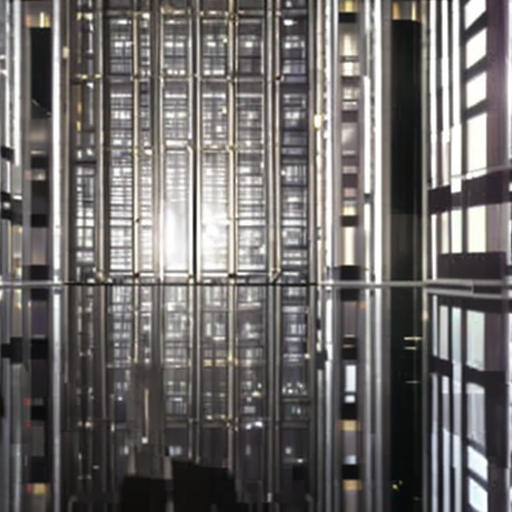

In [172]:
# find a good init image:

orig_prompt = "alleyway in a futuristic metropolis by night, beautiful reflections, photorealistic, 4k"
orig_negative_prompt = "low quality, noise, blur, blurred, text, watermark"

seed = 928766663
num_inference_steps = 20
guidance_scale = 9
height = 512
width = 512

num_images = 1
prompt = [orig_prompt] * num_images
negative_prompt = [orig_negative_prompt] * num_images

current_image = PIL.Image.new(mode="RGBA", size=(height, width))
mask_image = np.array(current_image)[:,:,3] 
mask_image = Image.fromarray(255-mask_image).convert("RGB")
current_image = current_image.convert("RGB")

images = pipe(prompt=prompt,
              negative_prompt=negative_prompt,
              image=current_image,
              guidance_scale = guidance_scale,
              height = height,
              width = width, 
              generator = g_cuda.manual_seed(seed),
              mask_image=mask_image, 
              num_inference_steps=num_inference_steps)[0]
current_image = images[0]

current_image

In [169]:
STEPSIZE = 10
NUMFRAMES = 50

all_frames = []
all_frames.append(current_image)

for i in range(NUMFRAMES):
  print('Generating image: ' + str(i+1) + ' / ' + str(NUMFRAMES))

  #shrink down by STEPSIZE
  prev_image = current_image.resize((height-2*STEPSIZE,width-2*STEPSIZE))
  prev_image = prev_image.convert("RGBA")
  prev_image = np.array(prev_image)

  #create blank non-transparent image
  blank_image = np.array(current_image.convert("RGBA"))*0
  blank_image[:,:,3] = 1

  #paste shrinked onto blank
  blank_image[STEPSIZE:height-STEPSIZE,STEPSIZE:width-STEPSIZE,:] = prev_image
  prev_image = Image.fromarray(blank_image)
  current_image = prev_image

  #create mask (black image with white STEPSIZE width edges)
  mask_image = np.array(current_image)[:,:,3] 
  mask_image = Image.fromarray(255-mask_image).convert("RGB")

  #inpaint
  current_image = current_image.convert("RGB")
  images = pipe(prompt=prompt,
                negative_prompt=negative_prompt,
                image=current_image,
                guidance_scale = guidance_scale,
                height = height,
                width = width, 
                #generator = g_cuda.manual_seed(seed),
                mask_image=mask_image, 
                num_inference_steps=num_inference_steps)[0]
  current_image = images[0]
  
  current_image.paste(prev_image, mask=prev_image)
  all_frames.append(current_image)
  clear_output(wait=True)

Generating image: 50 / 50


  0%|          | 0/20 [00:00<?, ?it/s]

In [170]:
write_video("infinite_zoom_out.mp4", all_frames, 16)

In [ ]:
#frame_one = all_frames[0]
#frame_one.save("all_frames.gif", format="GIF", append_images=all_frames[1:], save_all=True, duration=250, loop=0)